# Init

In [1]:
!pip install shap

In [2]:
import pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import shap
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
with open('pickle/df_target.p', 'rb') as file:
    df_target = pickle.load(file)
df_target.head()

,text,target
0,programa treinamento jornalismo agroindústria ...,10
1,ofício enviado sergio presidente michel esquiv...,6
2,governador sérgio cabral transferido complexo ...,6
3,aplausos federal sergio responsável operação i...,6
4,executivo empreiteira odebrecht afirmou acordo...,6


In [4]:
with open('pickle/tfidf.p', 'rb') as file:
    tfidf = pickle.load(file)

# TSNE

In [5]:
X = df_target.drop(columns=['target'])
y = df_target['target']

In [6]:
tfidf_matrix = tfidf.transform(X['text'])
X_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

In [7]:
scaler = StandardScaler()
X_tfidf = scaler.fit_transform(X_tfidf)

In [32]:
tsne = TSNE(n_components=2, random_state=0, perplexity=100, n_jobs=-1)
X_tsne = tsne.fit_transform(X_tfidf)

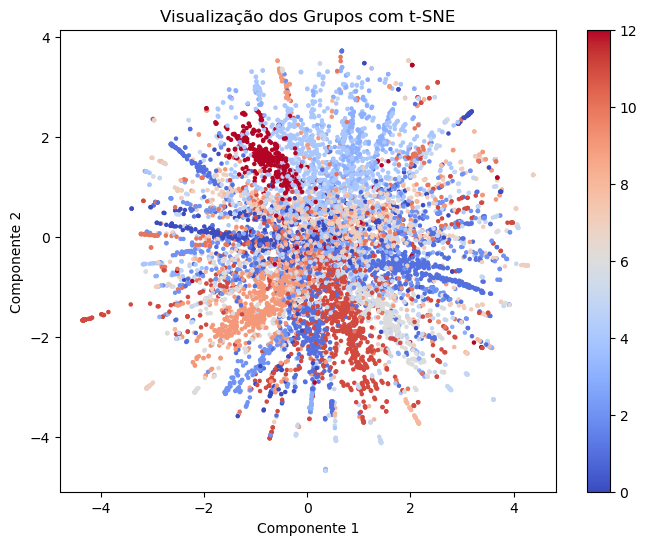

In [35]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='coolwarm', s=5)

# Adicionando uma barra de cores para indicar os clusters
plt.colorbar(scatter)
plt.title('Visualização dos Grupos com t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

# SHAP

In [36]:
with open('pickle/model_classifier.p', 'rb') as file:
    model_classifier = pickle.load(file)

In [37]:
X = df_target.drop(columns=['target'])
y = df_target['target']

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [39]:
x_train_tfidf = tfidf.transform(x_train['text'])
x_train_tfidf.shape

(8024, 5000)

In [40]:
x_test_tfidf = tfidf.transform(x_test['text'])
#x_test_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
x_test_tfidf.shape

(2006, 5000)

In [41]:
explainer = shap.LinearExplainer(model_classifier, x_train_tfidf.toarray())

In [42]:
shap_values = explainer.shap_values(x_test_tfidf)

In [43]:
shap_values.shape

(2006, 5000, 13)

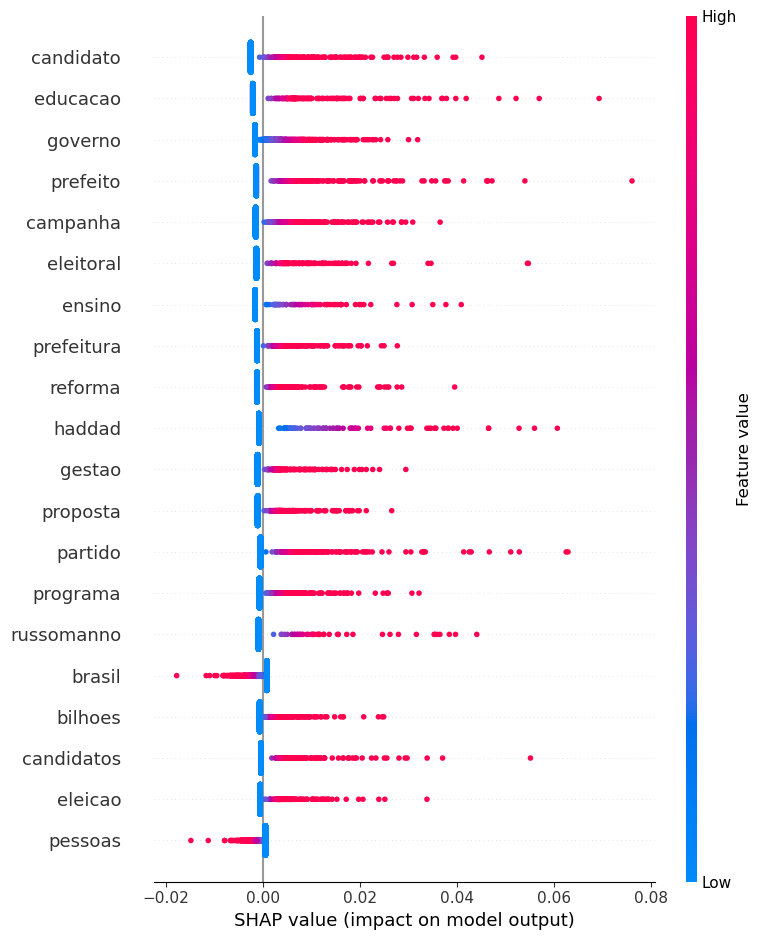

In [44]:
shap.summary_plot(
    shap_values[:,:,1], 
    x_test_tfidf.toarray(),
    feature_names=tfidf.get_feature_names_out()
)

In [45]:
shap_values_test = explainer(x_test_tfidf)

In [46]:
# numero previsto shap

shap.initjs()
shap.force_plot(
    explainer.expected_value[1], # classe escolhida para analise
    shap_values_test.values[1, :, 0], # primeiro indice acessa o SHAP value da amostra X
    x_test_tfidf.toarray()[0, :] # acessa os valores das features para a amostra X
)

In [47]:
# numero real 

shap.force_plot(
    explainer.expected_value[5],
    shap_values_test.values[1, :, 5],
    x_test_tfidf.toarray()[1, :]
)